In [153]:
%tensorflow_version 1.x

# 얼굴 인식

copy from : https://github.com/santhalakshminarayana/face-recognition/blob/master/Face_Recognition.ipynb

아티클 : https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5


# 데이터 준비

In [154]:
%cd /content

/content


In [155]:
!rm -rf __MACOSX
!rm -rf face_data.zip
!rm -rf face_data

https://github.com/eunahlee-viola/WISET-D_Offline/blob/master/Day3/Test_images.zip

아래 쎌에 들어있던 이미지 데이터 주소
https://github.com/dhrim/wiset_2020_06/raw/master/material/deep_learning/face_data.zip
https://github.com/eunahlee-viola/WISET-D_Offline/blob/master/Day3/face_data.zip

In [15]:
#!wget https://github.com/eunahlee-viola/WISET-D_Offline/blob/master/Day3/face_data.zip

--2020-06-24 01:26:38--  https://github.com/eunahlee-viola/WISET-D_Offline/blob/master/Day3/face_data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘face_data.zip.1’

face_data.zip.1         [  <=>               ]  72.68K   206KB/s    in 0.4s    

2020-06-24 01:26:40 (206 KB/s) - ‘face_data.zip.1’ saved [74427]



#이유는 모르겠으나, github에서 가져온 zip 파일이 70kb.. 
#Github에서 zip 파일 불러오는게 실패인듯
#이후로 아무것도 안됨.. ㅜ.ㅜ 

In [ ]:
#

Archive:  face_data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of face_data.zip or
        face_data.zip.zip, and cannot find face_data.zip.ZIP, period.


## 데이터 준비

아래와 같이 데이터를 준비한다.

```
face_data/
  Images/
    jobs_1.jpg
    jobs_2.jpg
    ...
    faker_1.jpg
    faker_2.jpg
    ...
    iu_1.jpg
    iu_2.jpg
  Test_images/
    jobs_11.jpg
    jobs_12.jpg
    ...
    faker_11.jpg
    faker_12.jpg
    ...
    iu_11.jpg
    iu_12.jpg
```



In [156]:
from google.colab import drive #EunAh: Google drive에 올리고 가져오는 과정 실행하고 나서 인증 필요
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
path='/content/face_data'

In [158]:
!cp "/content/drive/My Drive/content/face_data.zip" ./ #EunAh: 현재 위치에 가져오는 코드

In [159]:
!unzip face_data.zip #EunAh: 위에 파일가져오는 코드를 추가해 넣으면서 unzip 코드를 다시 추가했음

Archive:  face_data.zip
  inflating: Images/faker_1.jpg      
  inflating: Images/faker_10.jpg     
  inflating: Images/faker_11.jpg     
  inflating: Images/faker_15.jpg     
  inflating: Images/faker_16.jpg     
  inflating: Images/faker_18.jpg     
  inflating: Images/faker_2.jpg      
  inflating: Images/faker_21.jpg     
  inflating: Images/faker_22.jpg     
  inflating: Images/faker_23.jpg     
  inflating: Images/faker_24.jpg     
  inflating: Images/faker_3.jpg      
 extracting: Images/faker_7.jpg      
  inflating: Images/faker_8.jpg      
  inflating: Images/faker_9.jpg      
  inflating: Images/iu_10.jpg        
  inflating: Images/iu_11.jpg        
  inflating: Images/iu_12.jpg        
  inflating: Images/iu_13.jpg        
  inflating: Images/iu_14.jpg        
  inflating: Images/iu_15.jpg        
  inflating: Images/iu_16.jpg        
  inflating: Images/iu_17.jpg        
  inflating: Images/iu_2.jpg         
  inflating: Images/iu_21.jpg        
  inflating: Images/iu_22.

In [160]:
!mkdir face_data #EunAH: 압축 마다 방식이 달라 경로가 달라졌음. 이를 바로잡기 위해 파일 경로를 바로잡아줌
!mv Test_images face_data/
!mv Images face_data/

In [161]:
path='/content/face_data'

In [162]:
%cd $path

/content/face_data


In [163]:
import os
import glob

In [164]:
# Get Image names stored in "Images" folder
image_path_names=[]
person_names=set()
for file_name in glob.glob(path+'/Images/*_[1-9]*.jpg'):
  image_path_names.append(file_name)
  person_names.add(image_path_names[-1].split('/')[-1].split('_')[0])

In [165]:
len(image_path_names)

48

In [166]:
person_names

{'faker', 'iu', 'jobs', 'lea'}

  There are total 60 images containing 10 images per person.

# 얼굴부분 crop

얼굴 부분 탐지하여 crop한다.


dlib의 face detector를 사용

In [167]:
# Download Dlib CNN face detector
! wget http://dlib.net/files/mmod_human_face_detector.dat.bz2

--2020-06-24 03:40:11--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   522KB/s    in 1.3s    

2020-06-24 03:40:13 (522 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



In [168]:
!bzip2 -dk mmod_human_face_detector.dat.bz2

In [170]:
%rm mmod_human_face_detector.dat.bz2

In [171]:
import cv2
import matplotlib.pyplot as plt
import dlib

## DLIB FaceDetector 로딩

## Images 폴더 파일들 Crop

Images 폴더의 파일들을 읽어 Images_crop에 생성

In [172]:
# Load CNN face detector into dlib
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

In [173]:
os.mkdir(path+'/Images_crop/')

In [174]:
# For each person create a separate folder
for person in person_names:
  os.mkdir(path+'/Images_crop/'+person+'/')

In [175]:
# Detect face, crop detected face and save them in corresponding person folder
for file_name in image_path_names:
  img=cv2.imread(file_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue
  width=right-left
  height=bottom-top
  img_crop=img[top:top+height,left:left+width]
  img_path=path+'/Images_crop/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  cv2.imwrite(img_path,img_crop)

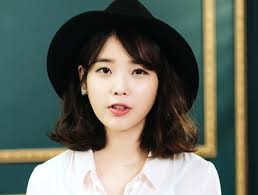

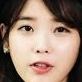

In [176]:
from IPython.display import Image
display(Image('Images/iu_10.jpg'))
display(Image('Images_crop/iu/iu_10.jpg'))

In [177]:
# Get Image names for testing
test_image_path_names=[]
for file_name in glob.glob(path+'/Test_images/*_*.jpg'):
  test_image_path_names.append(file_name)

In [178]:
len(test_image_path_names)

25

## Test_Image 파일들 crop

Test_Images의 파일들을 읽어 Test_Images_crop에 생성

In [179]:
os.mkdir(path+'/Test_Images_crop/')

In [180]:
# Create Separate folder for each person in "Test_Images_crop" folder
for person in person_names:
  os.mkdir(path+'/Test_Images_crop/'+person+'/')

In [181]:
# Detect face,crop face and save in corresponding folder
for file_name in test_image_path_names:
  img=cv2.imread(file_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue
  width=right-left
  height=bottom-top
  img_crop=img[top:top+height,left:left+width]
  img_path=path+'/Test_Images_crop/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  cv2.imwrite(img_path,img_crop)

<pre>Here images are sorted to corresponding test and train folders of same person
Directory structure :
|Images /
|  |-- (60 images)
|Images_crop /
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|Test_Images / 
|  |-- .. / (18 images)
|Test_Images_crop / 
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|mmod_human_face_detector.dat
</pre>

# VGG Face Model 다운로드

In [182]:
! pip install gdown

In [183]:
#Download pre-trained vgg-face-model-weights as .h5 file
! gdown https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo

Permission denied: https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo
Maybe you need to change permission over 'Anyone with the link'?


In [110]:
# EunAh: 위 Weight 가져오는데 permission denied 되어서 다운로드 받아 구글드라이브 링크를 추가
! gdown https://drive.google.com/file/d/1bgCVdhhwn_pH2MFw18iFcdven3Xo_7Ed/view?usp=sharing

/usr/local/lib/python2.7/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=1bgCVdhhwn_pH2MFw18iFcdven3Xo_7Ed
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/file/d/1bgCVdhhwn_pH2MFw18iFcdven3Xo_7Ed/view?usp=sharing
To: /content/face_data/view?usp=sharing
69.9kB [00:00, 605kB/s]


In [184]:
# EunAh: 그래도 안돼서 dropbox 링크로 추가 
! gdown https://www.dropbox.com/s/favuqa1zp09dfz7/vgg_face_weights.h5?dl=0

Downloading...
From: https://www.dropbox.com/s/favuqa1zp09dfz7/vgg_face_weights.h5?dl=0
To: /content/face_data/vgg_face_weights.h5?dl=0
377kB [00:00, 1.75MB/s]


파일이름이 달라진것 같음 끝에 이상한 "?dl=0" 이 붙었음. 어떻게 떼지? 이것 때문에 아래에서 불러오지 못하고 에러 발생하는듯

In [185]:
!mv vgg_face_weights.h5?dl=0 vgg_face_weights.ht #EunAh: 리눅스 파일이름 변경해주는 명령어

In [186]:
!mv vgg_face_weights.ht vgg_face_weights.h5 #EunAh: 오타 때문에 다시 실행 ㅜ.ㅜ

In [187]:
%ls -al

total 1108
drwxr-xr-x 6 root root   4096 Jun 24 03:42 ./
drwxr-xr-x 1 root root   4096 Jun 24 03:39 ../
drwxr-xr-x 2 root root   4096 Jun 24 03:39 Images/
drwxr-xr-x 6 root root   4096 Jun 24 03:41 Images_crop/
-rw-r--r-- 1 root root 729940 Oct  8  2016 mmod_human_face_detector.dat
drwxr-xr-x 2 root root   4096 Jun 24 03:39 Test_images/
drwxr-xr-x 6 root root   4096 Jun 24 03:41 Test_Images_crop/
-rw-r--r-- 1 root root 376528 Jun 24 03:41 vgg_face_weights.h5


In [188]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [189]:
#Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [192]:
# Load VGG Face model weights
model.load_weights('vgg_face_weights.h5')

OSError: ignored

In [133]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_39 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 112, 112, 128)    

In [134]:
# Remove Last Softmax layer and get model upto last flatten layer with outputs 2622 units
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

# 학습 모델 준비

In [135]:
#Prepare Training Data
x_train=[]
y_train=[]
person_folders=os.listdir(path+'/Images_crop/')
person_rep=dict()
for i,person in enumerate(person_folders):
  person_rep[i]=person
  image_names=os.listdir('Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(path+'/Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=vgg_face(img)
    x_train.append(np.squeeze(K.eval(img_encode)).tolist())
    y_train.append(i)

In [136]:
person_rep

{0: 'lea', 1: 'faker', 2: 'iu', 3: 'jobs'}

In [137]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [138]:
#Prepare Test Data
x_test=[]
y_test=[]
person_folders=os.listdir(path+'/Test_Images_crop/')
for i,person in enumerate(person_folders):
  image_names=os.listdir('Test_Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(path+'/Test_Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encode=vgg_face(img)
    x_test.append(np.squeeze(K.eval(img_encode)).tolist())
    y_test.append(i)

In [139]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [140]:
# Save test and train data for later use
np.save('train_data',x_train)
np.save('train_labels',y_train)
np.save('test_data',x_test)
np.save('test_labels',y_test)

In [141]:
# Load saved data
x_train=np.load('train_data.npy')
y_train=np.load('train_labels.npy')
x_test=np.load('test_data.npy')
y_test=np.load('test_labels.npy')

# 모델 정의

In [142]:
# Softmax regressor to classify images based on encoding 
classifier_model=Sequential()
classifier_model.add(Dense(units=100,input_dim=x_train.shape[1],kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=6,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='nadam',metrics=['accuracy'])

# 모델 학습

In [143]:
classifier_model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))

Train on 47 samples, validate on 25 samples
Epoch 1/100
47/47 [==============================] - 1s 29ms/sample - loss: 1.7646 - acc: 0.2979 - val_loss: 1.6797 - val_acc: 0.3200
Epoch 2/100
47/47 [==============================] - 0s 681us/sample - loss: 1.3303 - acc: 0.5532 - val_loss: 1.7295 - val_acc: 0.2400
Epoch 3/100
47/47 [==============================] - 0s 528us/sample - loss: 0.9666 - acc: 0.7872 - val_loss: 1.7293 - val_acc: 0.2000
Epoch 4/100
47/47 [==============================] - 0s 593us/sample - loss: 0.9826 - acc: 0.7234 - val_loss: 1.6024 - val_acc: 0.3200
Epoch 5/100
47/47 [==============================] - 0s 487us/sample - loss: 0.9499 - acc: 0.7660 - val_loss: 1.7449 - val_acc: 0.4400
Epoch 6/100
47/47 [==============================] - 0s 505us/sample - loss: 0.7605 - acc: 0.8298 - val_loss: 1.7777 - val_acc: 0.2000
Epoch 7/100
47/47 [==============================] - 0s 518us/sample - loss: 0.6907 - acc: 0.8723 - val_loss: 1.6694 - val_acc: 0.4400
Epoch 8/100


In [144]:
# Save model for later use
tf.keras.models.save_model(classifier_model,'face_classifier_model.h5')

In [145]:
# Load saved model
classifier_model=tf.keras.models.load_model('face_classifier_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [146]:
# Path to folder which contains images to be tested and predicted
test_images_path=path+'/Test_Images/'

In [ ]:
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

# 얼굴 인식 실행

In [147]:
def plot(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [150]:
# Label names for class numbers
# person_rep={0: 'iu', 1: 'jobs', 2: 'faker'}
person_rep={0: 'lea', 1: 'faker', 2: 'iu', 3: 'jobs'} # person 추가

In [151]:
os.mkdir(path+'/Predictions')

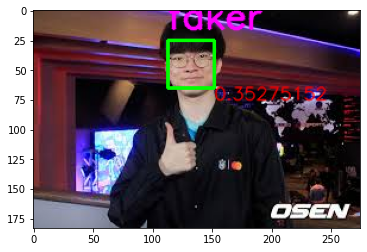

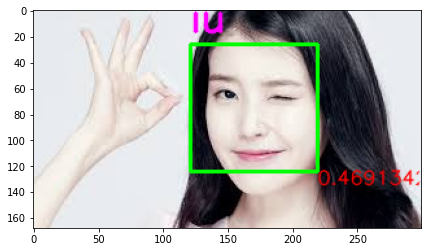

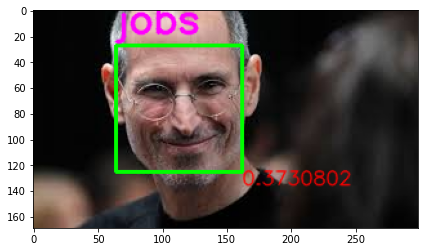

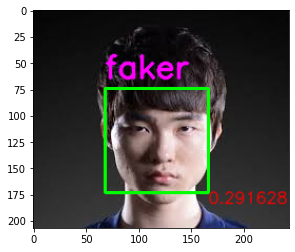

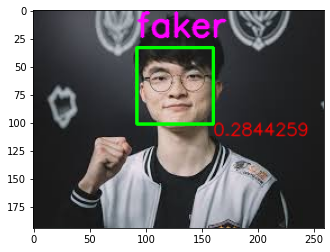

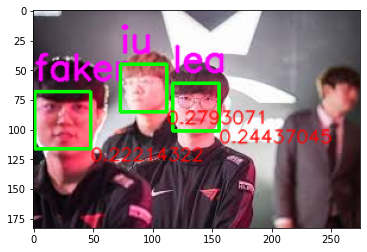

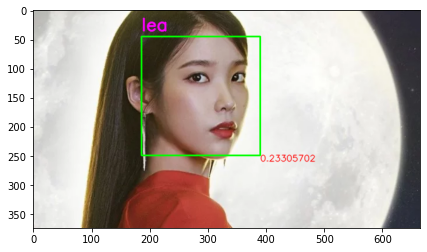

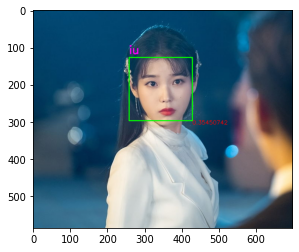

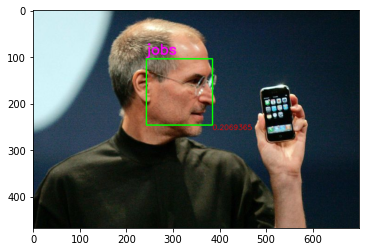

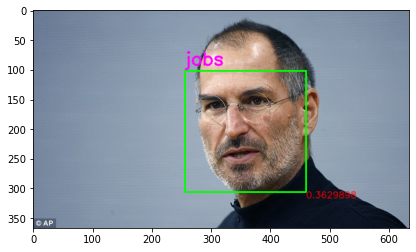

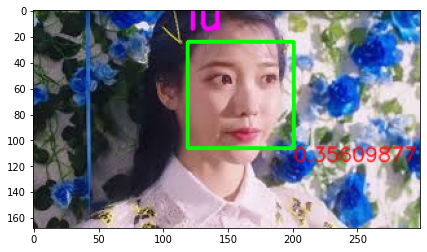

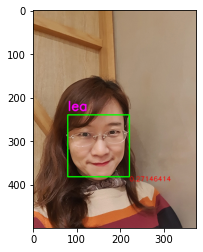

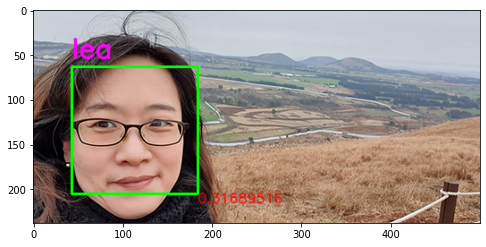

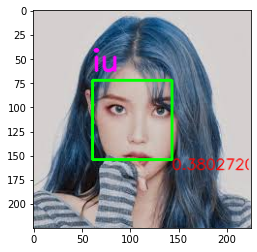

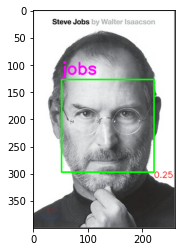

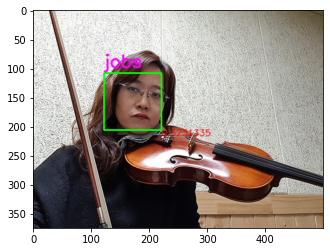

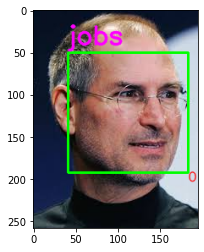

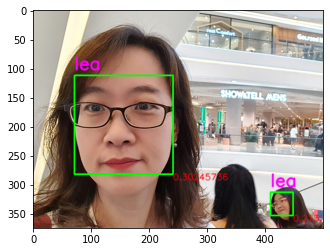

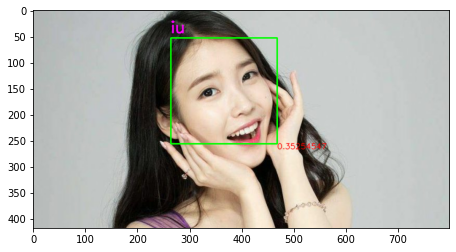

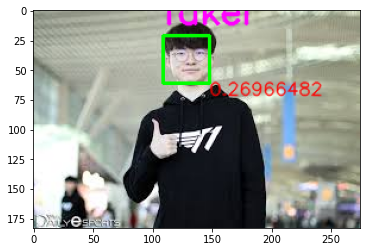

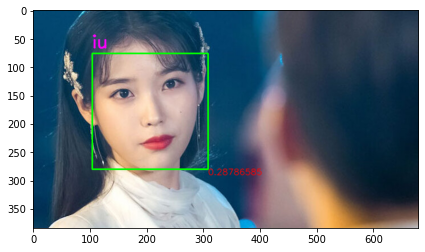

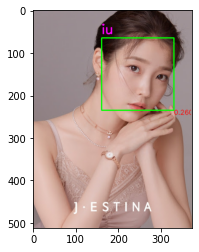

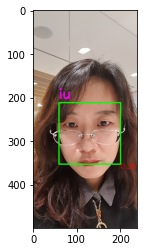

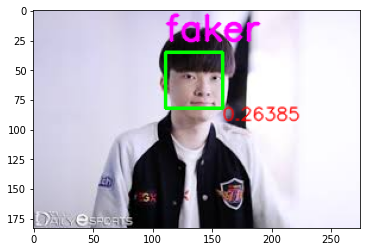

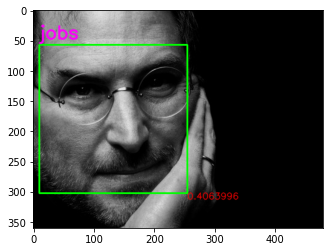

In [152]:
for img_name in os.listdir(path+'/Test_images/'):
  if img_name=='crop_img.jpg':
    continue
  # Load Image
  img=cv2.imread(path+'/Test_images/'+img_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 얼굴 탐지
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    # Extract Each Face
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
    width=right-left
    height=bottom-top
    img_crop=img[top:top+height,left:left+width]
    cv2.imwrite(path+'/Test_images/crop_img.jpg',img_crop)
    
    # 얼굴 영역 crop
    crop_img=load_img(path+'/Test_images/crop_img.jpg',target_size=(224,224))
    crop_img=img_to_array(crop_img)
    crop_img=np.expand_dims(crop_img,axis=0)
    crop_img=preprocess_input(crop_img)
    img_encode=vgg_face(crop_img)

    # 얼굴 영역 인식
    embed=K.eval(img_encode)
    person=classifier_model.predict(embed)
    name=person_rep[np.argmax(person)]
    os.remove(path+'/Test_images/crop_img.jpg')
    cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
    img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
  # Save images with bounding box,name and accuracy 
  cv2.imwrite(path+'/Predictions/'+img_name,img)
  plot(img)